In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Parameters
image_folder_base = 'ML/data/images'  # Replace with your images folder path
text_folder_base = 'ML/data/ocr'  # Replace with your text folder path
label_map = {0: 0, 2: 1, 4: 2, 6: 3, 9: 4}

# Image Transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Text Data and Labels
texts = []
labels = []
for label in label_map:
    image_folder = os.path.join(image_folder_base, str(label))
    text_folder = os.path.join(text_folder_base, str(label))
    for text_file in os.listdir(text_folder):
        with open(os.path.join(text_folder, text_file), 'r') as file:
            texts.append(file.read().strip())
        labels.append(label_map[label])

# Vectorize Text Data
vectorizer = TfidfVectorizer(max_features=1000)
text_features = vectorizer.fit_transform(texts).toarray()

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(text_features, labels, test_size=0.2, random_state=42)


In [6]:
image_paths = []
labels = []

for label in label_map:
    image_folder = os.path.join(image_folder_base, str(label))
    for img_file in os.listdir(image_folder):
        if img_file.endswith('.TIF') or img_file.endswith('.tif'):
            img_path = os.path.join(image_folder, img_file)
            image_paths.append(img_path)
            labels.append(label_map[label])

# Now split the image paths and labels into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [7]:
class ImageTextDataset(Dataset):
    def __init__(self, image_paths, text_data, labels, image_transform=None):
        self.image_paths = image_paths
        self.text_data = text_data
        self.labels = labels
        self.image_transform = image_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Image Processing
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.image_transform:
            image = self.image_transform(image)
        image = image.to(device)

        # Text Processing
        text = torch.tensor(self.text_data[idx], dtype=torch.float32).to(device)

        # Label
        label = torch.tensor(self.labels[idx], dtype=torch.long).to(device)

        return image, text, label

# Prepare Dataset
train_dataset = ImageTextDataset(image_paths=X_train_paths, text_data=X_train, labels=y_train, image_transform=image_transform)
test_dataset = ImageTextDataset(image_paths=X_test_paths, text_data=X_test, labels=y_test, image_transform=image_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
class CombinedModel(nn.Module):
    def __init__(self, text_input_dim, num_classes):
        super(CombinedModel, self).__init__()
        # Image Model (ResNet)
        self.image_model = models.resnet50(pretrained=True)
        num_ftrs = self.image_model.fc.in_features
        self.image_model.fc = nn.Linear(num_ftrs, 512)

        # Text Model (Fully Connected)
        self.text_model = nn.Sequential(
            nn.Linear(text_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )

        # Combined Classifier
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, image, text):
        image_features = self.image_model(image)
        text_features = self.text_model(text)
        combined_features = torch.cat((image_features, text_features), 1)
        output = self.classifier(combined_features)
        return output

# Initialize Model
model = CombinedModel(text_input_dim=X_train.shape[1], num_classes=len(label_map)).to(device)


/notebooks/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/notebooks/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from tqdm import tqdm

In [10]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize a list to store loss values
epoch_losses = []


# Training Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    epoch_losses.append(loss.item())

    

 10%|█         | 1/10 [02:33<22:59, 153.30s/it]

Epoch 1/10, Loss: 0.37976330518722534


 20%|██        | 2/10 [05:15<21:10, 158.77s/it]

Epoch 2/10, Loss: 0.33592668175697327


 30%|███       | 3/10 [08:11<19:25, 166.45s/it]

Epoch 3/10, Loss: 0.008939561434090137


 40%|████      | 4/10 [10:57<16:36, 166.10s/it]

Epoch 4/10, Loss: 0.0065602888353168964


 50%|█████     | 5/10 [13:26<13:20, 160.12s/it]

Epoch 5/10, Loss: 0.001970539567992091


 60%|██████    | 6/10 [15:51<10:19, 154.93s/it]

Epoch 6/10, Loss: 0.0986853539943695


 70%|███████   | 7/10 [18:46<08:04, 161.64s/it]

Epoch 7/10, Loss: 0.07657989114522934


 80%|████████  | 8/10 [21:23<05:20, 160.02s/it]

Epoch 8/10, Loss: 0.13203328847885132


 90%|█████████ | 9/10 [23:32<02:30, 150.32s/it]

Epoch 9/10, Loss: 0.00022754856036044657


100%|██████████| 10/10 [26:16<00:00, 157.68s/it]

Epoch 10/10, Loss: 0.00010280798596795648


In [11]:
import matplotlib.pyplot as plt

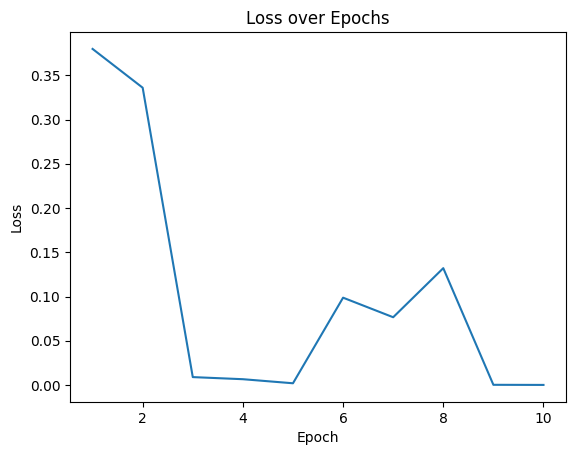

In [12]:
# After training, plot the loss over epochs
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [13]:
# Save the model checkpoint
torch.save(model.state_dict(), 'models/model_combined.pth')

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, texts, labels in test_loader:
            outputs = model(images, texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {accuracy}%')


Test Accuracy: 89.8%


In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, texts, labels in test_loader:
            outputs = model(images, texts)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


In [17]:
# Evaluate the model
true_labels, predicted_labels = evaluate_model(model, test_loader)

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:\n', conf_matrix)


Accuracy: 0.8980
Precision: 0.8992
Recall: 0.8980
F1 Score: 0.8979
Confusion Matrix:
 [[ 91   1   5   1   2]
 [  1  86   0   0   1]
 [  3   2  91   3   9]
 [  2   0   1 102   6]
 [  1   4   1   8  79]]


In [18]:
model_path = 'models/model_combined.pth'

# If you originally trained on a GPU and are now loading on a CPU:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# If you are loading on the same device type as you trained on:
model.load_state_dict(torch.load(model_path))

model.eval()  # Set the model to inference mode


CombinedModel(
  (image_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
